In [15]:
from utils.forecast import get_dwd_forecast
from typing import List
from datetime import datetime
from tqdm import tqdm

df = get_dwd_forecast(feature="precipitationTotal")
df.head()

,Unnamed: 0,call_time,station_id,provider,time,precipitationTotal
0,0,2023-12-15 00:10:00,Q811,DWD_1,2023-12-14 23:00:00,3
1,1,2023-12-15 00:10:00,Q811,DWD_1,2023-12-15 00:00:00,1
2,2,2023-12-15 00:10:00,Q811,DWD_1,2023-12-15 01:00:00,0
3,3,2023-12-15 00:10:00,Q811,DWD_1,2023-12-15 02:00:00,1
4,4,2023-12-15 00:10:00,Q811,DWD_1,2023-12-15 03:00:00,0


2023-12-07 23:00:00 2023-12-22 22:00:00


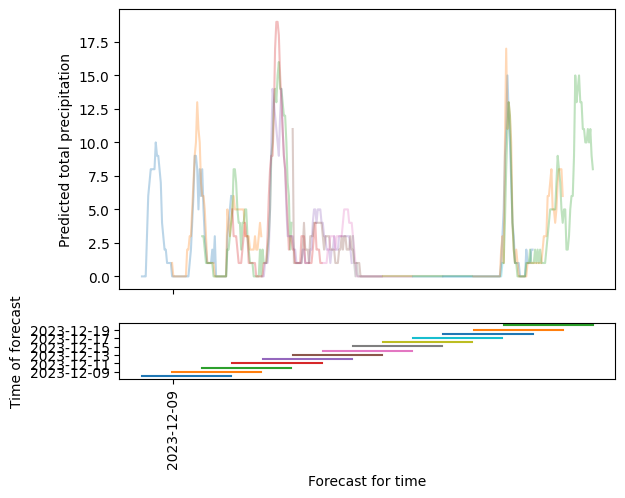

In [2]:
hourly = df[df["provider"] == "DWD_1"]
q811 = hourly[hourly["station_id"] == "Q811"]

from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
gs = gridspec.GridSpec(2, 1,height_ratios=[5,1])
ax1 = fig.add_subplot(gs[1])
ax0 = fig.add_subplot(gs[0], sharex=ax1)
axs = [ax0, ax1]

min_time = datetime(9999, 1, 1, 0, 0)
max_time = datetime(1, 1, 1, 0)
for call_time in sorted(q811["call_time"].unique())[1:]:
    api_call = q811[q811["call_time"] == call_time]
    
    sorted_df = api_call[["time", "precipitationTotal"]].sort_values(by=["time"])
    # print(sorted_df)
    axs[0].plot(sorted_df["time"], sorted_df["precipitationTotal"], alpha=0.3)
    left = min(sorted_df["time"])
    right = max(sorted_df["time"])
    axs[1].plot((left, right), (call_time, call_time))

    if left < min_time:
        min_time = left
    if right > max_time:
        max_time = right

plt.setp(ax0.get_xticklabels(), visible=False)
day_labels = [dt._text.split(" ")[0] for dt in axs[1].get_xticklabels()[::24]]
axs[1].set_xticks(axs[1].get_xticks()[::24], day_labels, rotation=90)

axs[0].set_ylabel("Predicted total precipitation")
axs[1].set_xlabel("Forecast for time")
axs[1].set_ylabel("Time of forecast")

print(min_time, max_time)

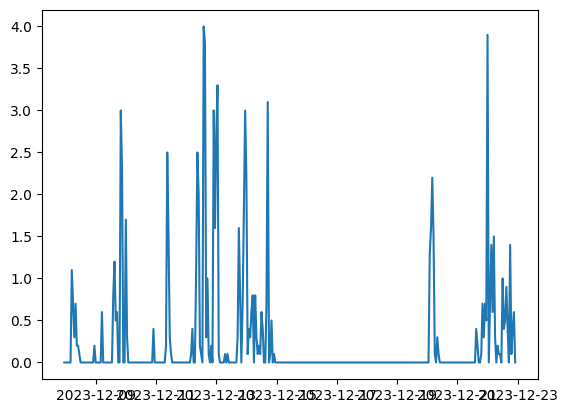

In [3]:
# find station id to Stationskennung Q811
import pandas as pd
import sys
sys.path.append("/".join(sys.path[0].split("/")[:-1]))

from studies.utils.recent import get_recent
from project.process.utils.download_dwd_data import FEATURE_STATION_PROPERTY_MAP
import glob

stations_df = pd.read_csv("../data/dwd/stations.tsv", sep="\t")

station_id = stations_df[stations_df["Stations-kennung"] == "Q811"]["Stations_ID"].unique()[0]


# load real data for station_id
property = "precipitation"
recent_df = get_recent(feature=property)
recent_df = recent_df.rename(columns={"MESS_DATUM": "time"})
recent_df = recent_df[recent_df["STATIONS_ID"] == station_id]
recent_df = recent_df[["STATIONS_ID", "time", "  R1"]]
recent_df = recent_df[recent_df["time"] >= min_time]
recent_df = recent_df[recent_df["time"] <= max_time]

# plot recent precipitation
fig, ax = plt.subplots()
ax.plot(recent_df["time"], recent_df["  R1"])

Here I want ot calculate the errors of a prediction

In [4]:
# load prediction
provider = "DWD_1"
station_id = "Q811"
feature = "precipitationTotal"

In [5]:
forecasts = get_dwd_forecast(feature)
forecasts = forecasts[forecasts["provider"] == provider]
# forecasts = forecasts[forecasts["station_id"] == station_id]
recent = get_recent("precipitation")
stations = pd.read_csv("../data/dwd/stations.tsv", sep="\t")

def get_station_id(stations_kennung: str):
    station_id = list(stations[stations["Stations-kennung"] == stations_kennung]["Stations_ID"].unique())[0]
    return station_id

forecasts["station_id"] = forecasts["station_id"].apply(get_station_id)

In [6]:
from studies.utils.forecast import set_errors_to_zeros


recent = recent.rename(columns={"MESS_DATUM": "time", "STATIONS_ID": "station_id"})
recent["  R1"] = recent["  R1"].apply(set_errors_to_zeros)
merge = pd.merge(forecasts, recent, on=["time", "station_id"], how="left")
merge = merge.assign(error=lambda x: x['precipitationTotal'] - x['  R1'])
# exclude station_id=1239
merge = merge[merge["station_id"] != 1239]

Text(0.5, 0, 'Datetime of comparison')

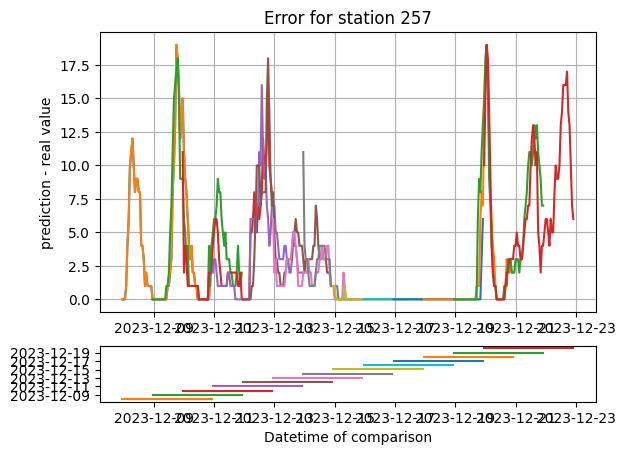

In [7]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1,height_ratios=[5,1])
ax1 = fig.add_subplot(gs[1])
ax0 = fig.add_subplot(gs[0], sharex=ax1)
axs = [ax0, ax1]

station_id = 257
axs[0].set_title(f"Error for station {station_id}")
for call_time in sorted(forecasts["call_time"].unique()):
    call_time_forecast = merge[(merge["call_time"] == call_time) & (merge["station_id"] == station_id)]
    forecast_time = call_time_forecast["time"]
    axs[0].plot(forecast_time, call_time_forecast["precipitationTotal"])
    axs[1].plot((min(forecast_time), max(forecast_time)), (call_time, call_time))

axs[0].grid()
axs[0].set_ylabel("prediction - real value")
axs[1].set_xlabel("Datetime of comparison")

We can obsever in this plot that the error is basically greater than zero. This means the forecast is more prone to predict more rain than in real life

Text(0.5, 0, 'time steps into the future')

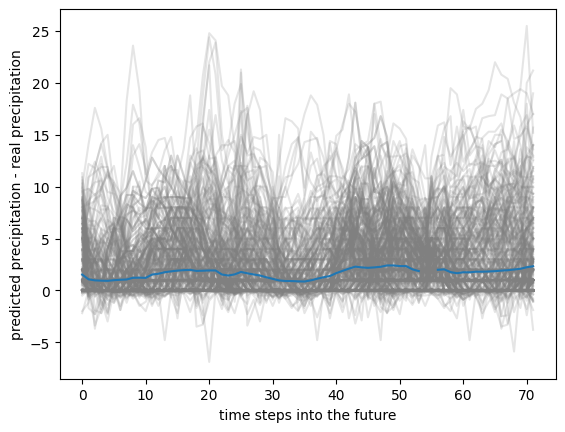

In [8]:
fig, ax = plt.subplots()
errors = []
station_ids = merge["station_id"].unique()
for call_time in merge["call_time"].unique():
    same_call_time = merge[merge["call_time"] == call_time]
    call_time_errors = []
    for station_id in station_ids:
        call_time_errors.append(same_call_time[same_call_time["station_id"] == station_id]["error"].values)
    errors.append(np.stack(call_time_errors))
    time = same_call_time["time"].values 
errors = np.stack(errors)
# errors = np.abs(errors)
# ax.plot(x, np.stack(errors).mean(axis=0))
for call_time_error in errors:
    for station_error in call_time_error:
        ax.plot(station_error, alpha=0.2, color="grey", label="individual station")
mean_error = np.concatenate(errors, axis=0).mean(axis=0) 
ax.plot(mean_error, label="mean")
ax.set_ylabel("predicted precipitation - real precipitation")
ax.set_xlabel("time steps into the future")

Do a permutation test for the whole error.  
H0: The forecast is not prone to overestimate nor underestimate precipitation 

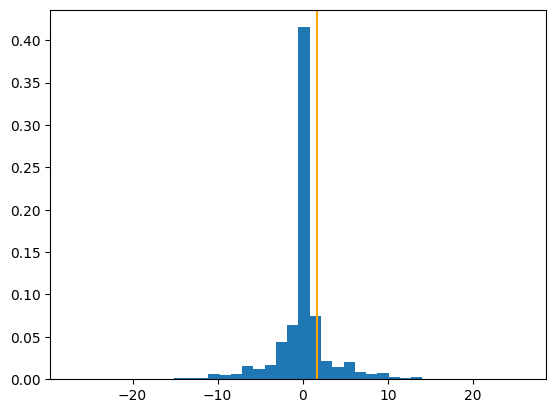

In [9]:
from sklearn.utils import shuffle

prediction = merge["precipitationTotal"].values
real = merge["  R1"].values

# exclude nan values
mask = np.isnan(prediction) + np.isnan(real)
prediction = prediction[~mask]
real = real[~mask]
mean_error = (prediction - real).mean()

data = np.concatenate([prediction, real])
scrambled = shuffle(data)
scrambled = np.stack([scrambled[:len(prediction)], scrambled[len(prediction):]])
error = scrambled[0] - scrambled[1]

fig, ax = plt.subplots()
hist, bins = np.histogram(error, bins=40, density=True)
ax.hist(error, bins=40, density=True)
ax.axvline(mean_error, color="orange")


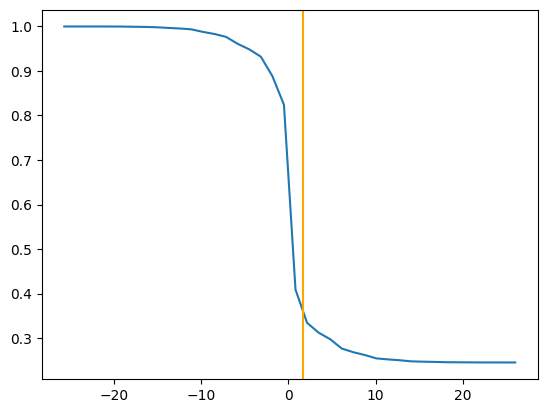

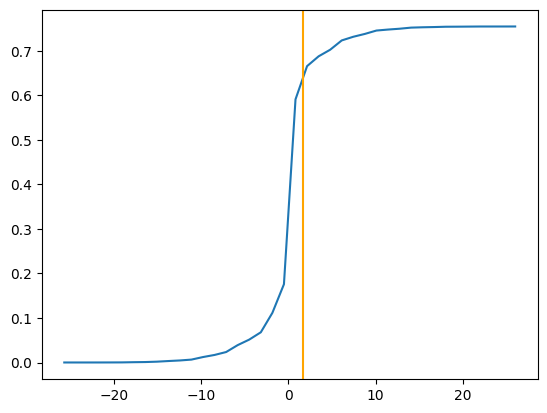

In [10]:
fig, ax = plt.subplots()
ax.plot(bins[1:], 1- hist.cumsum())
ax.axvline(mean_error, color="orange")

fig, ax = plt.subplots()
ax.plot(bins[1:], hist.cumsum())
ax.axvline(mean_error, color="orange")


IS one location espacially prone for errors?


Text(0, 0.5, 'prediction - real')

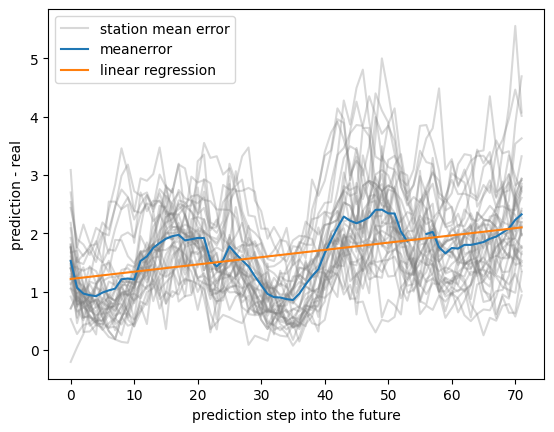

In [28]:
fig, ax = plt.subplots()
for station_id, station_error in zip(station_ids, errors.swapaxes(0, 1)):
    ax.plot(np.mean(station_error, axis=0), c="gray", alpha=0.3)

ax.plot(np.mean(station_error, axis=0), c="gray", alpha=0.3, label="station mean error")

mean_error = errors.mean(axis=0)
mean_error = mean_error.mean(axis=0)
ax.plot(mean_error, label="meanerror")

# line fitting
mask = np.isnan(mean_error)
x = np.arange(72)[:, None][~mask]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
coef = np.linalg.inv(x_aug.T @x_aug) @x_aug.T @ mean_error[~mask]

fit = x_aug @ coef
ax.plot(x, fit, label="linear regression")
ax.legend()
ax.set_xlabel("prediction step into the future")
ax.set_ylabel("prediction - real")

In [36]:
# do bootstrapping for each time step into the future and therefor get a confidence internal around the mean error
N_BOOT = 10000
N = 490  # The idea is to draw random samples with replacement from the original dataset, and the sample size influences the variability of the estimates.

boot_strap_means = []
for time_step_error in tqdm(errors.swapaxes(0, 2)):
    flatten_errors = time_step_error.flatten()
    simulated_errors = np.random.choice(flatten_errors, size=(N_BOOT, N), replace=True)
    boot_strap_means.append(simulated_errors.mean(axis=1))

boot_strap_means = np.stack(boot_strap_means)


100%|██████████| 72/72 [00:04<00:00, 15.21it/s]


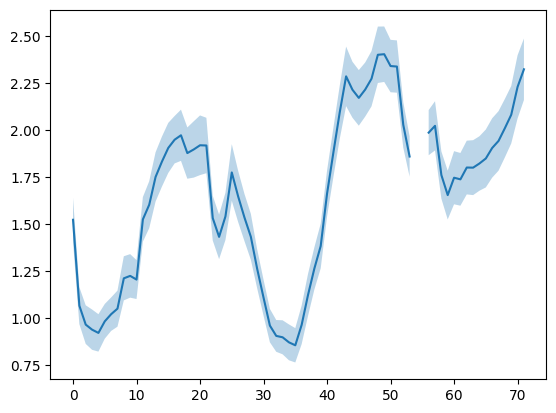

In [37]:
fig, ax = plt.subplots()
stds = np.std(boot_strap_means, axis=1)

ax.plot(mean_error)
ax.fill_between(np.arange(72), mean_error - stds, mean_error + stds, alpha=0.3)

IS one location espacially prone for errors?

Compute correlation between error and time to forecast?
Can we observe the same thing for temperature?

Can we do somehow bootstrapping?


Compute on average divergence for a forecast into the future. 
Observer how a forecast changes over time

